I wanted to try Transfer Learning using the [model](https://github.com/kkweon/mnist-competition/tree/master/model) pretrained on original MNIST Dataset, I got more than 98% accuracy in 5-epochs.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tmodelvgg5/vggnet5.h5
/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv


In [2]:
from keras.models import load_model

import matplotlib.pyplot as plt
from keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D, Activation
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

import keras.backend as K

Using TensorFlow backend.


In [3]:
Dig_MNIST = pd.read_csv("../input/Kannada-MNIST/Dig-MNIST.csv")
sample_submission = pd.read_csv("../input/Kannada-MNIST/sample_submission.csv")
test = pd.read_csv("../input/Kannada-MNIST/test.csv")
train = pd.read_csv("../input/Kannada-MNIST/train.csv")

**Pre-trained model** on original MNIST https://github.com/kkweon/mnist-competition/tree/master/model

In [4]:
model = load_model('/kaggle/input/tmodelvgg5/vggnet5.h5')

In [5]:
model.summary()

Model: "VGG5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 32)        0      

In [6]:
# Split the data
x = train.iloc[:,1:].values
y = train.iloc[:,0].values
y[:10]
x_test = test.drop('id', axis=1).iloc[:,:].values
x_dig = Dig_MNIST.drop('label', axis=1).iloc[:,:].values
y_dig = Dig_MNIST.label

# Reshape the data
x = x.reshape(x.shape[0], 28, 28, 1)
y = to_categorical(y, 10)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_dig = x_dig.reshape(x_dig.shape[0], 28, 28, 1)

# Split the data between train and test
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.10, random_state=42) 

# Artificially increase training set
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=10,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.1,
                                   zoom_range=0.25,
                                   horizontal_flip=False)

valid_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=10,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.1,
                                   zoom_range=0.25,
                                   horizontal_flip=False)

I have tried with lesser Learning Rates, what I observed was increasing the lr imporved accuracy with less epochs. So I have used lr=1e-2

In [7]:
batch_size =1024  # 64
num_classes = 10
epochs = 10 # 50
learning_rate=1e-2

In [8]:
optimizer = Adam(lr=learning_rate)

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [10]:
model.optimizer.lr

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.01>

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=200,
                                            verbose=1,
                                            factor=0.2)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

* Before I tried things like removing the last layer and adding a new layer and freezing the entire network except the last layer and then training I tried it for 20-50 epochs but it didn't work (val_loss and val_accuracy were bad).
* Freeze the entire network except the last layer (without removing it) then trained it.
* Train only the layers from Flatten till the last layer
* Remove the layers from Flatten and add new layers and train
* Remove up to last conv layers and add new layers and then train.
* None of them worked, then I just trained the model without any change with lr=1e-3, it worked, then I tried increasing and decreasing the lr. I observed increasing lr trained faster with good accuracy, So I choose lr=1e-2 (for lr>1e-2 the performance was poor)

In [12]:
%%time
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=valid_datagen.flow(x_valid, y_valid),
                              validation_steps=50,
                              callbacks=[learning_rate_reduction, es])

Epoch 1/10
100/100 [==============================] - 38s 377ms/step - loss: 0.5918 - accuracy: 0.8545 - val_loss: 21.8363 - val_accuracy: 0.0862
Epoch 2/10
100/100 [==============================] - 32s 315ms/step - loss: 0.0585 - accuracy: 0.9813 - val_loss: 8.7224 - val_accuracy: 0.1369
Epoch 3/10
100/100 [==============================] - 32s 318ms/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.2935 - val_accuracy: 0.9494
Epoch 4/10
100/100 [==============================] - 33s 326ms/step - loss: 0.0382 - accuracy: 0.9878 - val_loss: 0.0249 - val_accuracy: 0.9880
Epoch 5/10
100/100 [==============================] - 32s 318ms/step - loss: 0.0342 - accuracy: 0.9887 - val_loss: 0.0097 - val_accuracy: 0.9856
Epoch 6/10
100/100 [==============================] - 32s 319ms/step - loss: 0.0308 - accuracy: 0.9899 - val_loss: 0.0137 - val_accuracy: 0.9850
Epoch 7/10
100/100 [==============================] - 33s 325ms/step - loss: 0.0292 - accuracy: 0.9904 - val_loss: 0.0092 - val_a

In [13]:
model.optimizer.lr

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.01>

In [14]:
model.save('Tmodelx.h5')

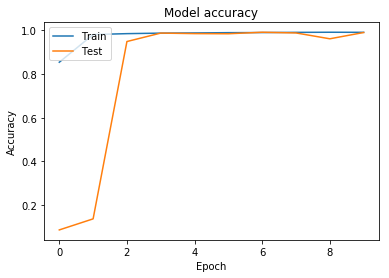

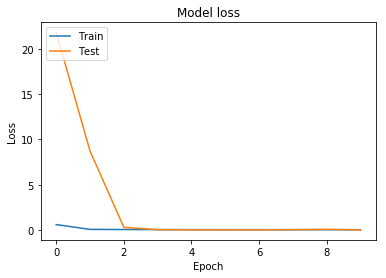

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
predictions = model.predict(x_test/255.)

In [17]:
preds = np.argmax(predictions, axis = 1)

In [18]:
submission = pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')
submission['label'] = preds
submission.to_csv("submission.csv", index=False)